In [1]:
from utils import datasets
from utils.parser import * 
import os 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf 
from models import * 
from utilities import *
from train_model_utilities import * 
import networkx as nx 
import tensorflow_addons as tfa 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def get_structure_from_adajancency(adajancency):
    structure = np.zeros(adajancency.shape)
    g = nx.DiGraph(adajancency) # train.A is the matrix where the direct connections are stored 
    for i in range(len(adajancency)):
        ancestors = list(nx.descendants(g, i)) #here we need to use the function nx.descendants() because in the directed graph the edges have source from the descendant and point towards the ancestor 
        if ancestors:
            structure[i, ancestors] = 1
    return structure 

def mymax1(prob, structure):
    structure = (structure + np.eye(structure.shape[0])).astype(np.float32)
    structure = structure[np.newaxis,:,:]
    prob = prob[:,:,tf.newaxis]
    prob1 = tf.reduce_max(prob * structure, axis=1)
    return prob1

In [3]:
dataset_name = 'seq_FUN'
train, valid, test = initialize_dataset(dataset_name, datasets)
structure = get_structure_from_adajancency(train.A)

scalar = StandardScaler().fit(train.X)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean').fit(train.X)
train.X = scalar.transform(imputer.transform(train.X))
valid.X = scalar.transform(imputer.transform(valid.X))
test.X = scalar.transform(imputer.transform(test.X))

train.Y = tf.convert_to_tensor(train.Y, tf.float32)
valid.Y = tf.convert_to_tensor(valid.Y, tf.float32)
test.Y = tf.convert_to_tensor(test.Y, tf.float32)

train_data = tf.data.Dataset.from_tensor_slices(
    (tf.concat([train.X, valid.X],axis=0), tf.concat([train.Y, valid.Y],axis=0))
).shuffle(buffer_size = (train.X.shape[0]+valid.X.shape[0])).batch(batch_size=4)

# Traditional binary log loss without postprocessing

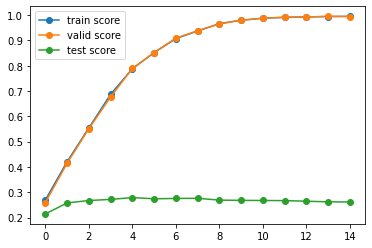

In [4]:
model = HMCModel(structure, 500, [2000,500], 0.7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5)

def loss_fn(y_true, y_logits):
    idx = tf.cast(tf.reduce_sum(y_true, axis=0) != y_true.shape[0], tf.float32) # remove root nodes
    loss = softplus(y_logits) + (1-y_true) * y_logits
    loss = tf.reduce_mean(loss * idx)
    return loss 

def train_a_step(model, optimizer, x_batch, y_batch):
    with tf.GradientTape() as tape:
        logits = model(x_batch)
        logits = model.postprocess(logits)
        loss = loss_fn(y_batch, logits)
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
    return loss 

def train_epochs(model, optimizer, train_data, epochs):
    steps = (train.X.shape[0]+valid.X.shape[0]) // 4
    loss_list = []
    train_score_list = []
    valid_score_list = []
    test_score_list = []
    for epoch in range(epochs):
        loss = 0
        for x_batch, y_batch in train_data.take(steps):
            loss += train_a_step(model, optimizer, x_batch, y_batch)
        loss /= steps
        loss_list.append(loss) 
        train_score = custom_score(train.Y, model.predict(train.X))
        valid_score = custom_score(valid.Y, model.predict(valid.X))
        test_score = custom_score(test.Y, model.predict(test.X))
        train_score_list.append(train_score)
        valid_score_list.append(valid_score)
        test_score_list.append(test_score)
    return loss_list, train_score_list, valid_score_list, test_score_list

loss_list, train_score_list, valid_score_list, test_score_list = train_epochs(model, 
                                                                              optimizer, 
                                                                              train_data, 
                                                                              15)
plt.plot(train_score_list, '-o', label='train score')
plt.plot(valid_score_list, '-o', label = 'valid score')
plt.plot(test_score_list, '-o', label = 'test score')
plt.legend()

In [5]:
test_score_list

[0.21445563122896474,
 0.25793517855536163,
 0.26732263007566703,
 0.27185238532370015,
 0.2788768358789615,
 0.2742052297411498,
 0.27554588087724924,
 0.2762122329570255,
 0.2689075458287449,
 0.26802304423756684,
 0.2674554765856307,
 0.2670121124532072,
 0.2645481266059104,
 0.262197481573126,
 0.26152579917750635]

# Postprocessing and MCM loss

In [15]:
model = HMCModel(structure, 500, [2000,2000], 0.7)
optimizer = tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)

def mylog(x):
    x = tf.where(x < 1e-30, 1e-30, x)
    return tf.math.log(x)

# def cross_y_log(y,prob):
#     ''' return y * log(prob), to avoid 0 * log(0)'''
#     r = tf.where(y != 0, y * mylog(prob), 0)
#     return r 

def loss_fn(y_true, y_logits, structure):
    idx = tf.cast(tf.reduce_sum(y_true, axis=0) != y_true.shape[0], tf.float32) # remove root nodes
    prob = tf.nn.sigmoid(y_logits)
    part1 = - y_true * mylog(mymax1(prob * y_true, structure))
    part2 = - (1-y_true) * mylog(1 - mymax1(prob, structure))
    loss = part1 + part2
    loss = tf.reduce_mean(loss * idx)
    return loss 

def loss_fn_funny(y_true, y_logits, structure):
    idx = tf.squeeze(tf.where(tf.reduce_sum(y_true, axis=0) != y_true.shape[0])) # remove root nodes
    prob = model.get_prob(y_logits)
    c_out = mymax1(prob, structure)
    t_out = y_true * prob
    t_out = mymax1(t_out, structure)
    t_out = (1-y_true) * c_out + y_true * t_out
    y_true1 = tf.gather(y_true, idx, axis=1)
    t_out1 = tf.gather(t_out, idx, axis=1)
    loss = tf.losses.BinaryCrossentropy(from_logits=False)(
        y_true1, t_out1
    )
    return loss

def train_a_step(model, optimizer, x_batch, y_batch, structure):
    with tf.GradientTape() as tape:
        logits = model(x_batch)
        loss = loss_fn_funny(y_batch, logits, structure)
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
    return loss 

def train_epochs(model, optimizer, train_data, epochs, structure):
    steps = (train.X.shape[0]+valid.X.shape[0]) // 4
    loss_list = []
    train_score_list = []
    valid_score_list = []
    test_score_list = []
    for epoch in range(epochs):
        loss = 0
        for x_batch, y_batch in train_data.take(steps):
            loss += train_a_step(model, optimizer, x_batch, y_batch, structure)
        loss /= steps
        loss_list.append(loss) 
        train_score = custom_score(train.Y, model.predict(train.X))
        valid_score = custom_score(valid.Y, model.predict(valid.X))
        test_score = custom_score(test.Y, model.predict(test.X))
        train_score_list.append(train_score)
        valid_score_list.append(valid_score)
        test_score_list.append(test_score)
    return loss_list, train_score_list, valid_score_list, test_score_list

loss_list, train_score_list, valid_score_list, test_score_list = train_epochs(model, 
                                                                              optimizer, 
                                                                              train_data, 
                                                                              30,
                                                                              structure)
plt.plot(train_score_list, '-o', label='train score')
plt.plot(valid_score_list, '-o', label = 'valid score')
plt.plot(test_score_list, '-o', label = 'test score')
plt.legend()

KeyboardInterrupt: 

In [13]:
test_score_list

[0.13662807704996371,
 0.1684745061446835,
 0.20072915178386064,
 0.21736697892924453,
 0.2312183563112142,
 0.24002892725323843,
 0.24851794752044204,
 0.2547531752354483,
 0.25904750401055715,
 0.26246186449980874,
 0.2682450872393318,
 0.271120919798836,
 0.2747438255548903,
 0.27646502379961646,
 0.27876322906126416,
 0.28314694884463393,
 0.28399395218327006,
 0.28398738137295715,
 0.28720692955317717,
 0.28850730434050836,
 0.2880662311857941,
 0.28968757404400736,
 0.2920219145603601,
 0.29026528819893593,
 0.2915969501893222,
 0.2932151909160071,
 0.2931551244837861,
 0.2940410499065939,
 0.29276508043986865,
 0.2945744638367554]

# Model with logits 

In [4]:
model = HMCModel(structure, 500, [2000,2000], 0.7)
optimizer = tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)

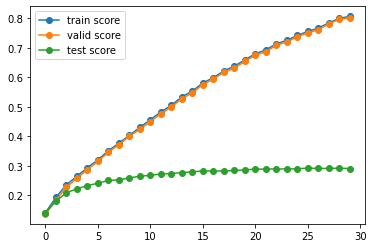

In [10]:
model = HMCModel(structure, 500, [2000,2000], 0.7)
optimizer = tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)

def get_z(y_true):
    @tf.custom_gradient
    def get_z_fn(logits):
        outputs = tf.where(y_true == 1, logits, -np.inf)
        def grad(upstream):
            return upstream * tf.where(y_true == 1, 1.0, 0.0)
        return outputs, grad
    return get_z_fn
def mymax2(logits, structure):
    structure = (structure + np.eye(structure.shape[0])).astype(np.float32)
    structure = np.where(structure == 1, structure, -np.inf)
    structure = np.where(structure==1, 0, structure)
    structure = structure[np.newaxis,:,:]
    logits = logits[:,:,tf.newaxis]
    outputs = tf.reduce_max(structure + logits, axis=1)
    return outputs

def loss_fn(y_true, y_logits, structure):
    get_z_fn = get_z(y_true)
    z = get_z_fn(y_logits)
    max_x = mymax2(y_logits, structure)
    max_z = mymax2(z, structure)
    part1 = y_true * softplus(max_z)
    part2 = (1-y_true) * max_x
    part3 = (1-y_true) * softplus(max_x)
    return tf.reduce_mean(part1 + part2 + part3)

def train_a_step(model, optimizer, x_batch, y_batch, structure):
    with tf.GradientTape() as tape:
        logits = model(x_batch)
        loss = loss_fn(y_batch, logits, structure)
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
    return loss 

def train_epochs(model, optimizer, train_data, epochs, structure):
    steps = (train.X.shape[0]+valid.X.shape[0]) // 4
    loss_list = []
    train_score_list = []
    valid_score_list = []
    test_score_list = []
    for epoch in range(epochs):
        loss = 0
        for x_batch, y_batch in train_data.take(steps):
            loss += train_a_step(model, optimizer, x_batch, y_batch, structure)
        loss /= steps
        loss_list.append(loss) 
        train_score = custom_score(train.Y, model.predict(train.X))
        valid_score = custom_score(valid.Y, model.predict(valid.X))
        test_score = custom_score(test.Y, model.predict(test.X))
        train_score_list.append(train_score)
        valid_score_list.append(valid_score)
        test_score_list.append(test_score)
    return loss_list, train_score_list, valid_score_list, test_score_list

loss_list, train_score_list, valid_score_list, test_score_list = train_epochs(model, 
                                                                              optimizer, 
                                                                              train_data, 
                                                                              30,
                                                                              structure)
plt.plot(train_score_list, '-o', label='train score')
plt.plot(valid_score_list, '-o', label = 'valid score')
plt.plot(test_score_list, '-o', label = 'test score')
plt.legend()

In [13]:
test_score_list[:10]

[0.14010853701181122,
 0.18029002115709297,
 0.20906508316794828,
 0.22223712089349046,
 0.23305186441784176,
 0.24091271933739908,
 0.25052908839942295,
 0.2526472439439416,
 0.2589185450957492,
 0.2649115178863571]

# HMC-LSTM original model

In [6]:
# we need to sort train.Y by class layers, that means the 1st column is the root, the 2nd to the 
# k-th are the second layer, ...
def get_root(g):
    ''' 
    g is a digraph
    '''
    roots = list()
    for n in g.nodes():
        ancenstors = list(nx.descendants(g,n)) # here we have to use descendants, because the data is structured to point descendants to ancenstors
        if len(ancenstors) == 0:
            roots.append(n)
    return roots

def get_label_layers(A):
    '''
    A is the adajancency matrix
    '''
    g = nx.DiGraph(A)
    nodes = get_root(g)
    layers = dict()
    n_left = A.shape[0]
    i = 0
    while n_left > 0:
        layers[i] = nodes
        i += 1
        n_left -= len(nodes)
        descendants = list()
        for n in nodes:
            all_descendants = list(nx.ancestors(g, n))
            descendants_n = [x for x in all_descendants if nx.shortest_path_length(g,x,n) <= 1]
            descendants = descendants + descendants_n
        nodes = descendants
    return layers 

def preprocess_labels(A, Y):
    ''' 
    A is the adajancency matrix, Y is the label matrix
    '''
    layers = get_label_layers(A)
    col_idx = list()
    num_layers = len(layers.keys())
    class_list = list()
    for i in range(num_layers):
        col_idx = col_idx + layers[i]
        class_list.append(len(layers[i]))
    labels = tf.gather(Y,col_idx,axis=1)
    new_A = A[col_idx][:,col_idx]
    
    return num_layers, col_idx, labels, layers, class_list, new_A

num_layers, col_idx, labels, layers, class_list, new_A = preprocess_labels(train.A, tf.concat([train.Y, valid.Y], axis=0))
test_labels = tf.gather(test.Y, col_idx, axis=1)

In [7]:
train_data = tf.data.Dataset.from_tensor_slices(
    (tf.concat([train.X, valid.X],axis=0), labels)
).shuffle(buffer_size = (train.X.shape[0]+valid.X.shape[0])).batch(batch_size=4)

In [8]:
from utilities import get_loss_fn_lstm
model = HMC_LSTM(500, 0.5, class_list, num_layers, [2000], 0.7)
loss_fn = get_loss_fn_lstm(new_A, 0.5, 0.5)
optimizer = tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)

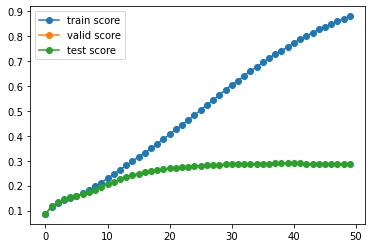

In [9]:
def train_a_step(model, optimizer, x_batch, y_batch):
    with tf.GradientTape() as tape:
        logits = model(x_batch)
        loss = loss_fn(y_batch, logits)
        variables = model.trainable_variables 
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
    return loss 

def train_epochs(model, optimizer, train_data, epochs):
    steps = (train.X.shape[0]+valid.X.shape[0]) // 4
    loss_list = []
    train_score_list = []
    valid_score_list = []
    test_score_list = []
    for epoch in range(epochs):
        loss = 0
        for x_batch, y_batch in train_data.take(steps):
            loss += train_a_step(model, optimizer, x_batch, y_batch)
        loss /= steps
        loss_list.append(loss) 
        train_score = custom_score(labels, model.predict(tf.concat([train.X, valid.X],axis=0)))
        test_score = custom_score(test_labels, model.predict(test.X))
        train_score_list.append(train_score)
        test_score_list.append(test_score)
    return loss_list, train_score_list, valid_score_list, test_score_list

loss_list, train_score_list, valid_score_list, test_score_list = train_epochs(model, 
                                                                              optimizer, 
                                                                              train_data, 
                                                                              50)
plt.plot(train_score_list, '-o', label='train score')
plt.plot(valid_score_list, '-o', label = 'valid score')
plt.plot(test_score_list, '-o', label = 'test score')
plt.legend()

In [11]:
test_score_list[-20:]

[0.28595677958010113,
 0.2857891924388157,
 0.28774054853562087,
 0.28703899977514835,
 0.28863252089832503,
 0.2882727634643109,
 0.2883056959826833,
 0.28940510817053133,
 0.289286425308548,
 0.28914205806540233,
 0.28882075534603047,
 0.2890310400949317,
 0.28829149428722783,
 0.2879449377987278,
 0.28742161090451523,
 0.287549337937857,
 0.28764900763117546,
 0.2874661125295296,
 0.28725576133531705,
 0.28646378815179185]

# HMC-LSTM with hierarchical log loss

In [22]:
# we need to sort train.Y by class layers, that means the 1st column is the root, the 2nd to the 
# k-th are the second layer, ...
def get_root(g):
    ''' 
    g is a digraph
    '''
    roots = list()
    for n in g.nodes():
        ancenstors = list(nx.descendants(g,n)) # here we have to use descendants, because the data is structured to point descendants to ancenstors
        if len(ancenstors) == 0:
            roots.append(n)
    return roots

def get_label_layers(A):
    '''
    A is the adajancency matrix
    '''
    g = nx.DiGraph(A)
    nodes = get_root(g)
    layers = dict()
    n_left = A.shape[0]
    i = 0
    while n_left > 0:
        layers[i] = nodes
        i += 1
        n_left -= len(nodes)
        descendants = list()
        for n in nodes:
            all_descendants = list(nx.ancestors(g, n))
            descendants_n = [x for x in all_descendants if nx.shortest_path_length(g,x,n) <= 1]
            descendants = descendants + descendants_n
        nodes = descendants
    return layers 

def preprocess_labels(A, Y):
    ''' 
    A is the adajancency matrix, Y is the label matrix
    '''
    layers = get_label_layers(A)
    col_idx = list()
    num_layers = len(layers.keys())
    class_list = list()
    for i in range(num_layers):
        col_idx = col_idx + layers[i]
        class_list.append(len(layers[i]))
    labels = tf.gather(Y,col_idx,axis=1)
    new_A = A[col_idx][:,col_idx]
    
    return num_layers, col_idx, labels, layers, class_list, new_A

num_layers, col_idx, labels, layers, class_list, new_A = preprocess_labels(train.A, tf.concat([train.Y, valid.Y], axis=0))
test_labels = tf.gather(test.Y, col_idx, axis=1)

In [23]:
train_data = tf.data.Dataset.from_tensor_slices(
    (tf.concat([train.X, valid.X],axis=0), labels)
).shuffle(buffer_size = (train.X.shape[0]+valid.X.shape[0])).batch(batch_size=4)

In [24]:
from utilities import get_loss_fn_lstm
model = HMC_LSTM(1000, 0.5, class_list, num_layers, [2000], 0.7)
loss_fn = get_loss_fn_log(new_A, 0.5)
optimizer = tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-6)

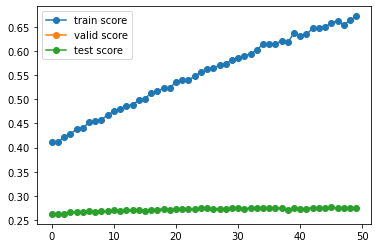

In [28]:
def train_a_step(model, optimizer, x_batch, y_batch):
    with tf.GradientTape() as tape:
        logits = model(x_batch)
        loss = loss_fn(y_batch, logits)
        variables = model.trainable_variables 
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
    return loss 

def train_epochs(model, optimizer, train_data, epochs):
    steps = (train.X.shape[0]+valid.X.shape[0]) // 4
    loss_list = []
    train_score_list = []
    valid_score_list = []
    test_score_list = []
    for epoch in range(epochs):
        loss = 0
        for x_batch, y_batch in train_data.take(steps):
            loss += train_a_step(model, optimizer, x_batch, y_batch)
        loss /= steps
        loss_list.append(loss) 
        train_score = custom_score(labels, model.predict(tf.concat([train.X, valid.X],axis=0)))
        test_score = custom_score(test_labels, model.predict(test.X))
        train_score_list.append(train_score)
        test_score_list.append(test_score)
    return loss_list, train_score_list, valid_score_list, test_score_list

loss_list, train_score_list, valid_score_list, test_score_list = train_epochs(model, 
                                                                              optimizer, 
                                                                              train_data, 
                                                                              50)
plt.plot(train_score_list, '-o', label='train score')
plt.plot(valid_score_list, '-o', label = 'valid score')
plt.plot(test_score_list, '-o', label = 'test score')
plt.legend()

In [30]:
test_score_list[-20:]

[0.2739392962332782,
 0.2737675657693601,
 0.2744490389245256,
 0.274909529025679,
 0.2750207525961825,
 0.275012286568983,
 0.2747111770932818,
 0.2740044478357401,
 0.27136230576628073,
 0.2753007867103503,
 0.2734851113002745,
 0.2738376179682704,
 0.2753671256181654,
 0.2747216940319176,
 0.2741976036771141,
 0.27602332526850637,
 0.2750290362285618,
 0.27405783602394124,
 0.2749647429937466,
 0.2746243553133191]

In [ ]:

p1 = 0.